In [1]:
import sys
sys.path.insert(0,'/Users/marcosaponara/Desktop/MY_CENTIPEDE_GAME/CODE/mysrc')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from json import load

from itertools import product
from tqdm import tqdm

from egttools.analytical import PairwiseComparison, replicator_equation
from egttools.games import Matrix2PlayerGameHolder
from egttools.utils import calculate_stationary_distribution

from egttools.plotting import draw_invasion_diagram
from egttools.plotting.simplified import plot_replicator_dynamics_in_simplex#, plot_moran_dynamics_in_simplex

from utils.centipedeGame import CentipedeGame
from utils.kStrategy import KStrategy


from utils.kernel import eps_kernel_sym as kernel

In [3]:
from scipy.spatial.distance import jensenshannon

def hellinger(p : np.ndarray, 
              q : np.ndarray,
             ):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2, axis = -1)) / np.sqrt(2)

In [4]:
with open('/Users/marcosaponara/Desktop/MY_CENTIPEDE_GAME/CODE/mysrc/data/data.json') as f:
    data = load(f)

In [5]:
gameid = 'icg4'

In [6]:
icgdata = data['data'][gameid]

nb_steps = icgdata['nb_steps']
payoffs_pl1 = np.array(icgdata['payoffs_pl1'], dtype = float)
payoffs_pl2 = np.array(icgdata['payoffs_pl2'], dtype = float)
experimental_reference = np.array(icgdata['experimental_reference'], dtype = float)


In [7]:
beta, eps, gamma = 10., 0.09, 0.

Z = 1000

In [8]:
nb_k_levels = nb_steps + 1
k_levels = np.arange(nb_k_levels)

In [9]:
aa = np.zeros(nb_steps + 2, dtype = float)
aa[-1] = 1.
aa[nb_steps//2] = 1.

start_arrays = np.array([
                        aa,
                        ], dtype = float)

assert start_arrays.shape[1] == nb_steps + 2

start_k_pairs = list(product(start_arrays, k_levels))
nb_strategies = len(start_k_pairs)

In [10]:
ker = kernel(nb_steps, gamma, eps)
strategy = KStrategy(ker)

strategies = []
for pair in start_k_pairs:
    start, k = pair
    strategies.append(strategy.calculate_mixed_strategy(start = start, k = k))
strategies = np.array(strategies)
nb_strategies = len(strategies)

cg = CentipedeGame(payoffs_pl1, payoffs_pl2, strategies)
payoffs = cg.payoffs()

game = Matrix2PlayerGameHolder(nb_strategies, payoffs)

evolver = PairwiseComparison(population_size=Z, game=game)
transition_matrix, fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(beta)
stationary_distribution = calculate_stationary_distribution(transition_matrix.transpose())


In [11]:
for pair in start_k_pairs:
    print(pair)

for strategy in strategies:
    print(strategy)

(array([0., 0., 1., 0., 0., 1.]), 0)
(array([0., 0., 1., 0., 0., 1.]), 1)
(array([0., 0., 1., 0., 0., 1.]), 2)
(array([0., 0., 1., 0., 0., 1.]), 3)
(array([0., 0., 1., 0., 0., 1.]), 4)
[0. 0. 1. 0. 0. 1.]
[0.045 0.045 0.91  0.045 0.91  0.045]
[0.083925 0.83215  0.083925 0.12285  0.83215  0.045   ]
[0.15126525 0.76480975 0.083925   0.83740488 0.11759513 0.045     ]
[0.76935522 0.14671978 0.083925   0.83740488 0.11759513 0.045     ]


In [12]:
if gameid=='icg6':
    payoffsSUBSET = payoffs[2:5, 2:5]
    type_labels = ['k=2', 'k=3', 'k=4']

elif gameid=='icg4':
    payoffsSUBSET = payoffs[1:4, 1:4]
    type_labels = ['k=1', 'k=2', 'k=3']

In [13]:
payoffsSUBSET

array([[1.8957125 , 0.79109453, 0.56280547],
       [2.00074729, 0.96195441, 0.51597633],
       [1.18860143, 0.97430173, 0.5523828 ]])

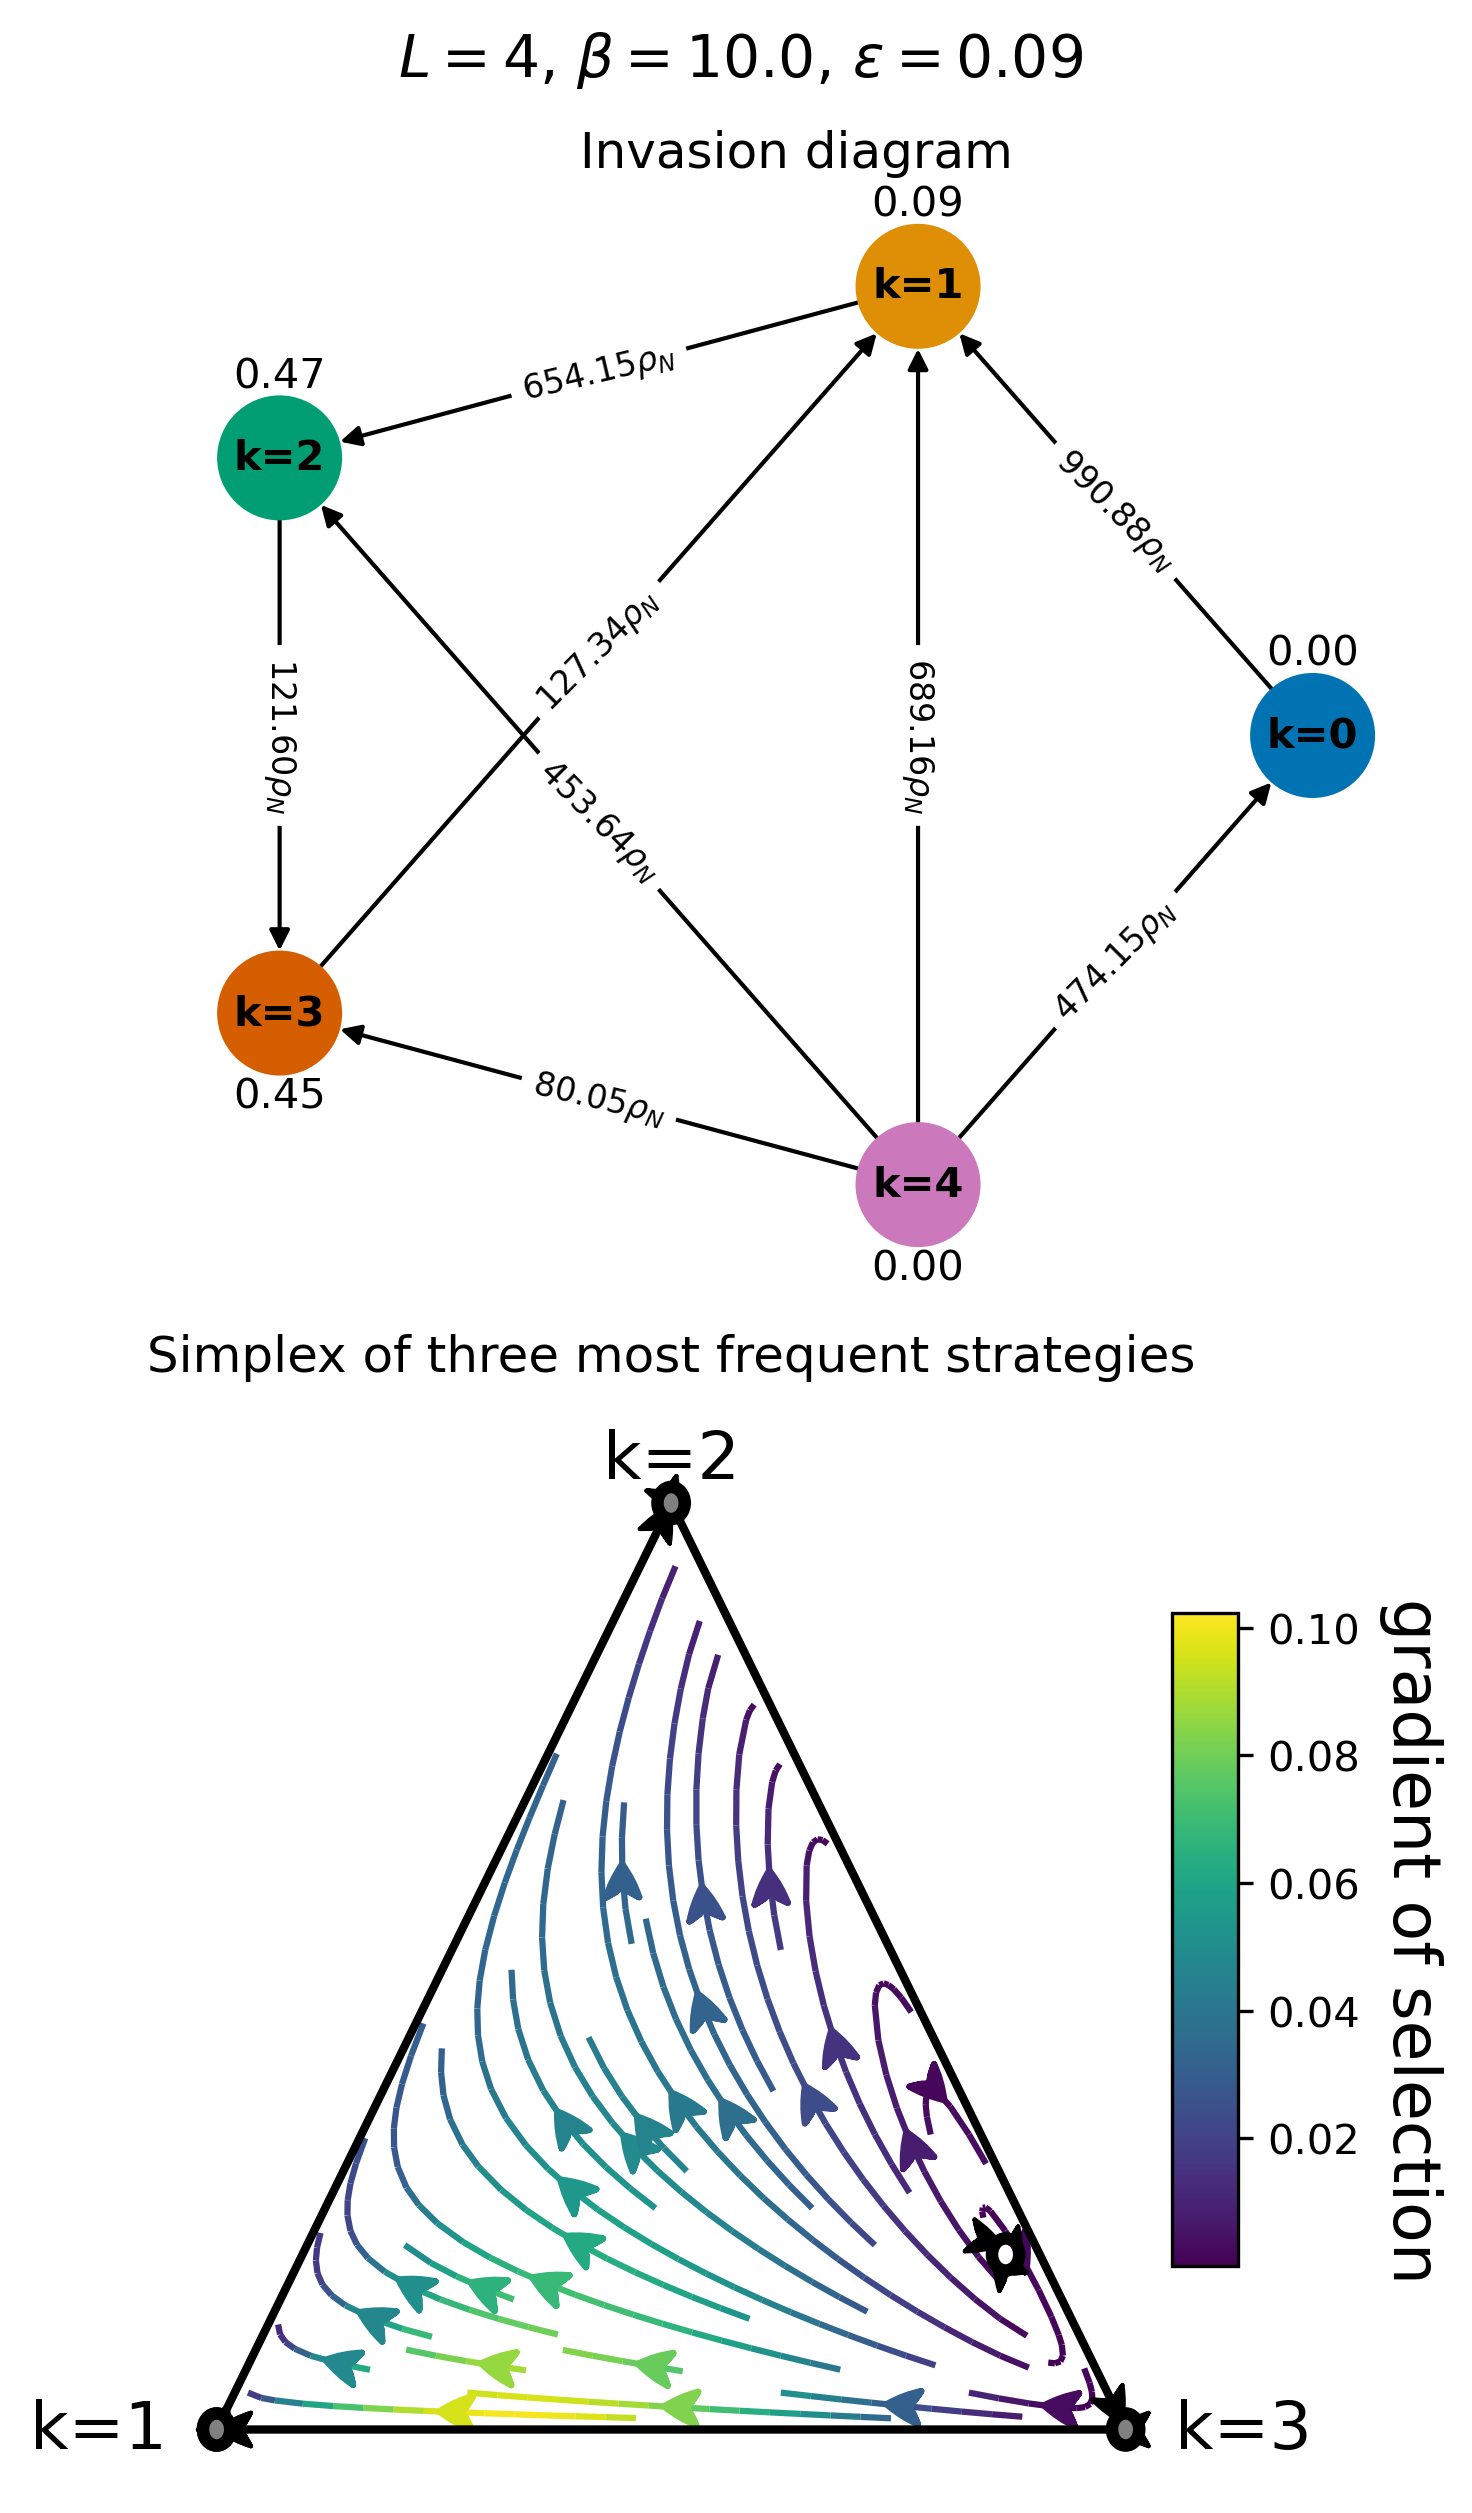

In [14]:
title = r'$L=$' + str(nb_steps) + r', $\beta=$' + str(beta) + ', $\epsilon=$' + str(eps)

figure, axis = plt.subplots(2, 1, dpi=300, figsize=(5,8.5))

figure.suptitle(title, fontsize=14)

G = draw_invasion_diagram(['k='+str(i) for i in range(nb_strategies)],
                          1/Z, 
                          fixation_probabilities, 
                          stationary_distribution,
                          node_size=900, 
                          font_size_node_labels=10,
                          font_size_edge_labels=8,
                          font_size_sd_labels=10,
                          edge_width=1.,
                          min_strategy_frequency = -0.1, 
                          ax=axis[0],
                         )
axis[0].set_title('Invasion diagram')
axis[0].axis('off')

simplex, gradients, roots, roots_xy, stability = plot_replicator_dynamics_in_simplex(payoffsSUBSET, ax=axis[1])

plot = (simplex.add_axis(ax=axis[1])
       .draw_triangle()
       .draw_gradients(zorder=0)
       .add_colorbar()
       .add_vertex_labels(type_labels, epsilon_bottom=0.13)
       .draw_stationary_points(roots_xy, stability)
       .draw_trajectory_from_roots(lambda u, t: replicator_equation(u, payoffsSUBSET), 
                                   roots,
                                   stability,
                                   trajectory_length=15,
                                   linewidth=1,
                                   step=0.01,
                                   color='k', 
                                   draw_arrow=True, 
                                   arrowdirection='right', 
                                   arrowsize=20, 
                                   zorder=4, 
                                   arrowstyle='fancy',
                                  )
       #.draw_scatter_shadow(lambda u, t: replicator_equation(u, payoffsSUBSET), 300, color='gray', marker='.', s=0.1, zorder=0)
      )

axis[1].axis('off')
# axis[1].set_aspect('equal')

axis[1].set_xlim((-.05,1.05))
axis[1].set_ylim((-.05, simplex.top_corner + 0.1))
axis[1].set_title(r'Simplex of three most frequent strategies')

figure.tight_layout()
plt.savefig('./figures/fig3.png',format='png')
plt.savefig('./figures/fig3_vec.svg',format='svg')
plt.show()